# 2.0.0: Model performance

Let's take a look at how our different models perform. There are quite a few models to compare, so there are a few ways we can visualize and assess performance.

For instance, we trained models for each of 33 traits for 3 "trait sets" (i.e. the provenance of the gridded trait data: sPlot-only, GBIF-only, and sPlot + GBIF combined). Below we will explore both general, trait set-level trends as well as zoom in on 8 traits specifically to assess trait-level trends.

## Imports and config

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.conf.conf import get_config
from src.conf.environment import log
from src.utils.dataset_utils import get_latest_run, get_models_dir
from src.utils.trait_utils import get_trait_name_from_id

cfg = get_config()

## Model performance across all traits and trait sets

Collect the trait model directories and load one model to familiarize with the results DataFrame structure.

In [2]:
model_dirs = [
    d for d in get_models_dir().glob("*") if d.is_dir() and d.name.startswith("X")
]

pd.read_csv(
    get_latest_run(model_dirs[0] / "autogluon") / "splot" / "evaluation_results.csv",
    index_col=0,
    header=[0, 1],
)

root_mean_squared_error           mean_squared_error            \
                         mean       std               mean       std   
index                                                                  
0                   -0.368086  0.012683          -0.135616  0.009276   

      mean_absolute_error                  r2            pearsonr            \
                     mean       std      mean       std      mean       std   
index                                                                         
0               -0.204339  0.004746  0.166738  0.039199  0.414134  0.039704   

      median_absolute_error           norm_root_mean_squared_error            
                       mean       std                         mean       std  
index                                                                         
0                 -0.140822  0.005529                     -0.20829  0.011431

Aggregate the performance statistics of all trait models for all trait sets into a master results DataFrame.

In [3]:
def aggregate_results() -> pd.DataFrame:
    """One df to rule them all."""
    model_dirs = [
        d for d in get_models_dir().glob("*") if d.is_dir() and d.name.startswith("X")
    ]

    results = []
    for model_dir in model_dirs:
        trait_id = model_dir.name
        run_dir = get_latest_run(model_dir / "autogluon")
        for trait_set in [d for d in run_dir.glob("*") if d.is_dir()]:
            trait_set_name = trait_set.name
            df = pd.read_csv(
                trait_set / cfg.train.eval_results, index_col=0, header=[0, 1]
            ).reset_index(drop=True)

            df.index = pd.MultiIndex.from_tuples(
                [(trait_id, trait_set_name)], names=["trait_id", "trait_set"]
            )

            df.columns.names = ["metric", "agg"]
            results.append(df)

    return pd.concat(results)


results = aggregate_results()
results.head(6)

metric               root_mean_squared_error           mean_squared_error  \
agg                                     mean       std               mean   
trait_id  trait_set                                                         
X163_mean splot                    -0.368086  0.012683          -0.135616   
          gbif                     -0.420192  0.014170          -0.176722   
          splot_gbif               -0.375389  0.012784          -0.141048   
X27_mean  splot                    -2.016579  0.157927          -4.086543   
          gbif                     -2.335387  0.160611          -5.474669   
          splot_gbif               -2.072859  0.165621          -4.318687   

metric                         mean_absolute_error                  r2  \
agg                        std                mean       std      mean   
trait_id  trait_set                                                      
X163_mean splot       0.009276           -0.204339  0.004746  0.166738   
          gbif        0.011693           -0.291559  0.011715 -0.085262   
          splot_gbif  0.009504           -0.225392  0.006673  0.133546   
X27_mean  splot       0.632074           -1.442928  0.126860  0.265491   
          gbif        0.753288           -1.601680  0.146086  0.015250   
          splot_gbif  0.686592           -1.453772  0.137980  0.224240   

metric                          pearsonr           median_absolute_error  \
agg                        std      mean       std                  mean   
trait_id  trait_set                                                        
X163_mean splot       0.039199  0.414134  0.039704             -0.140822   
          gbif        0.030400  0.288524  0.030736             -0.240633   
          splot_gbif  0.034698  0.393044  0.036042             -0.168700   
X27_mean  splot       0.062661  0.517037  0.059662             -1.044294   
          gbif        0.057820  0.313109  0.058655             -1.065891   
          splot_gbif  0.062974  0.481721  0.063871             -1.034581   

metric                         norm_root_mean_squared_error            
agg                        std                         mean       std  
trait_id  trait_set                                                    
X163_mean splot       0.005529                    -0.208290  0.011431  
          gbif        0.009732                    -0.237682  0.010543  
          splot_gbif  0.008107                    -0.212406  0.011207  
X27_mean  splot       0.106359                    -0.188465  0.011826  
          gbif        0.138393                    -0.218256  0.010693  
          splot_gbif  0.114903                    -0.193686  0.011628

Define a few helper functions to allow us to use human-readable trait names and units instead of only trait IDs as defined in the TRY database.

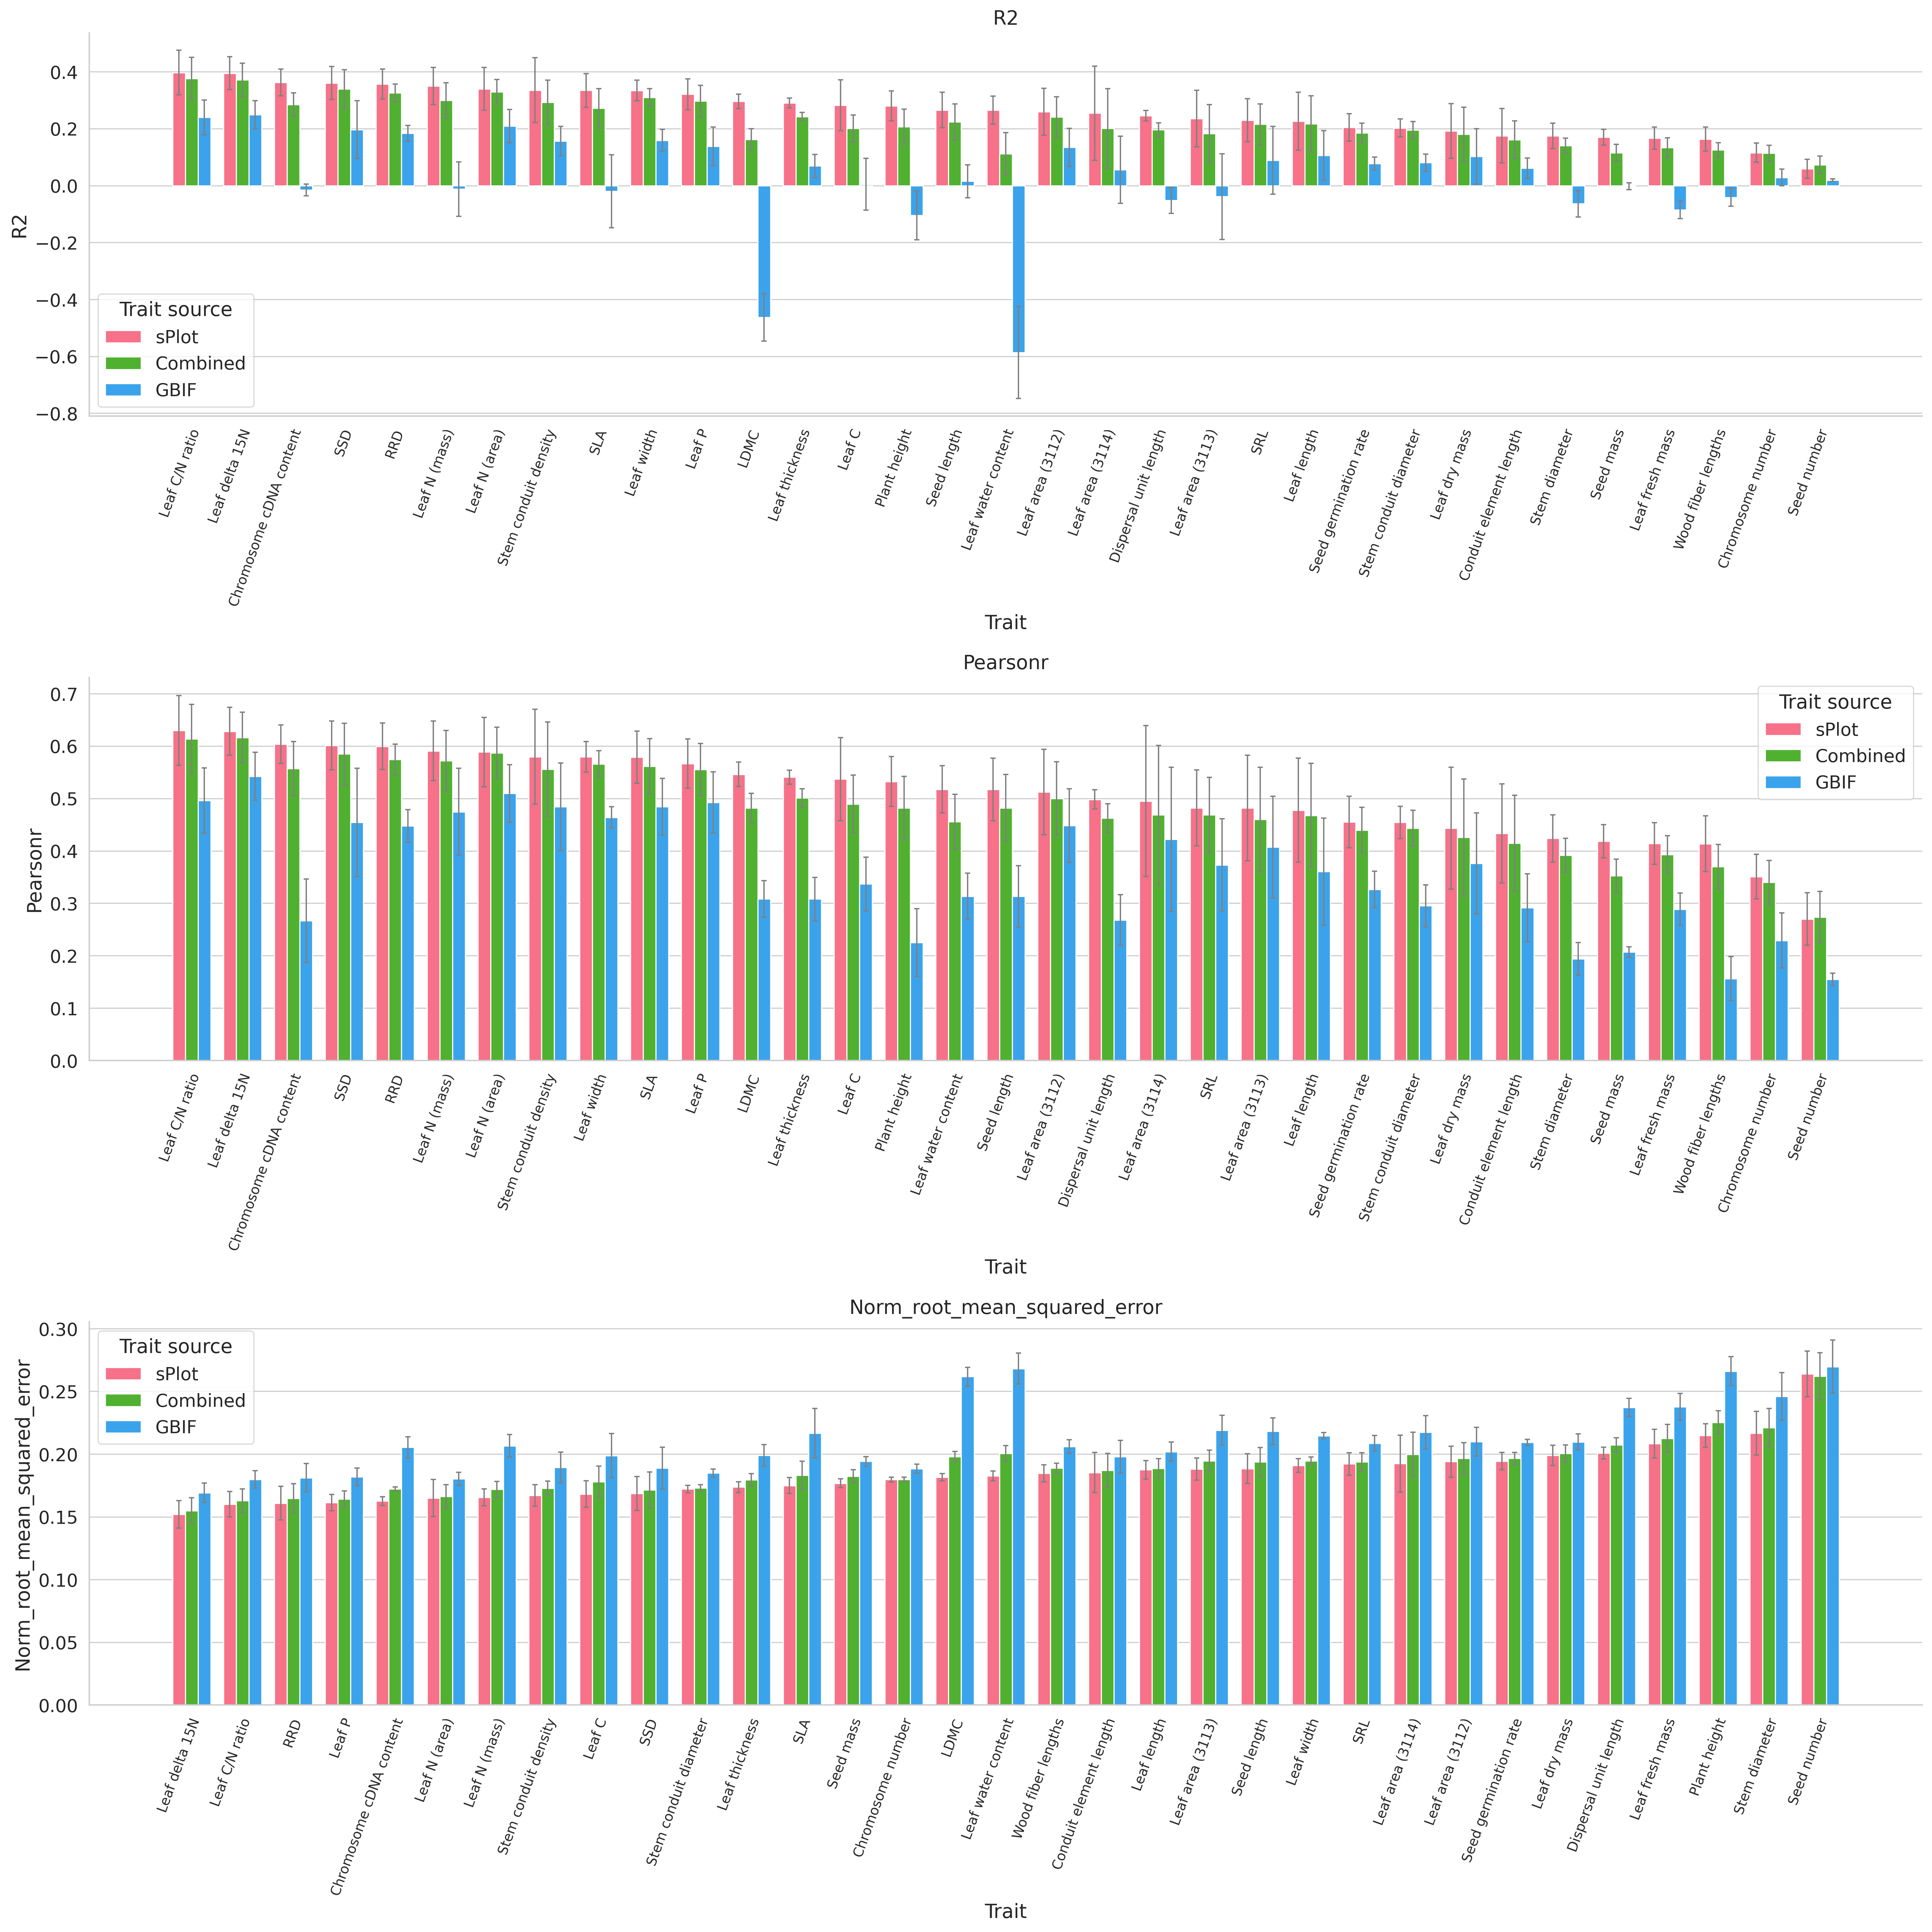

In [4]:
# Prepare data
treatments = ["splot", "splot_gbif", "gbif"]
metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]

# Set the color palette for treatments
colors = sns.color_palette("husl", len(treatments))
color_dict = dict(zip(treatments, colors))

with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    # Create subplots for each metric
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 20), dpi=300)

    for idx, metric in enumerate(metrics):
        traits = (
            results.sort_values(by=(metric, "mean"), ascending=False)
            .index.get_level_values("trait_id")
            .unique()
        )
        ax = axs[idx]

        # Prepare data for the current metric
        data = []
        for trait_id in traits:
            trait_name = get_trait_name_from_id(trait_id)[0]
            for treatment in treatments:
                mean_value = results.loc[(trait_id, treatment), (metric, "mean")]
                std_value = results.loc[(trait_id, treatment), (metric, "std")]

                if metric == "norm_root_mean_squared_error":
                    mean_value = abs(mean_value)

                data.append([trait_name, treatment, mean_value, std_value])

        df = pd.DataFrame(
            data, columns=["trait_name", "treatment", "mean_value", "std_value"]
        )

        # Create bar plot with error bars
        bar_width = 0.3  # Bar width
        gap = 0.3  # Gap between groups of bars
        x = np.arange(len(traits)) * (len(treatments) * bar_width + gap)

        error_kw = {
            "elinewidth": 1,  # Error bar thickness
            "ecolor": "grey",  # Error bar color
            "capsize": 2,  # Cap size for error bars
        }

        def map_treatment(treatment: str) -> str:
            if treatment == "splot":
                return "sPlot"
            if treatment == "splot_gbif":
                return "Combined"
            if treatment == "gbif":
                return "GBIF"
            else:
                raise ValueError(f"Unknown treatment {treatment}")

        for i, treatment in enumerate(treatments):
            subset = df[df["treatment"] == treatment]
            ax.bar(
                x + i * bar_width,
                subset["mean_value"],
                yerr=subset["std_value"],
                width=bar_width,
                label=map_treatment(treatment),
                color=color_dict[treatment],
                error_kw=error_kw,
            )

        ax.set_title(f"{metric.capitalize()}")
        ax.set_xlabel("Trait")
        ax.set_ylabel(metric.capitalize())
        ax.set_xticks(
            (x + bar_width * (len(treatments) - 1) / 2) - 0.05,
            [get_trait_name_from_id(t)[0] for t in traits],
            rotation=70,
            ha="right",
            va="top",
            rotation_mode="anchor",
            fontsize=10,
        )
        # ax.set_xticklabels([get_trait_name_from_id(t)[0] for t in traits], rotation=90)
        ax.legend(title="Trait source")

        # Set y-axis limits for R²
        # if metric == "r2":
        #     ax.set_ylim(0)

        sns.despine()
        ax.grid(False, axis="x")

    plt.tight_layout()
    plt.show()

### Violin plots aggregating all traits for each trait set

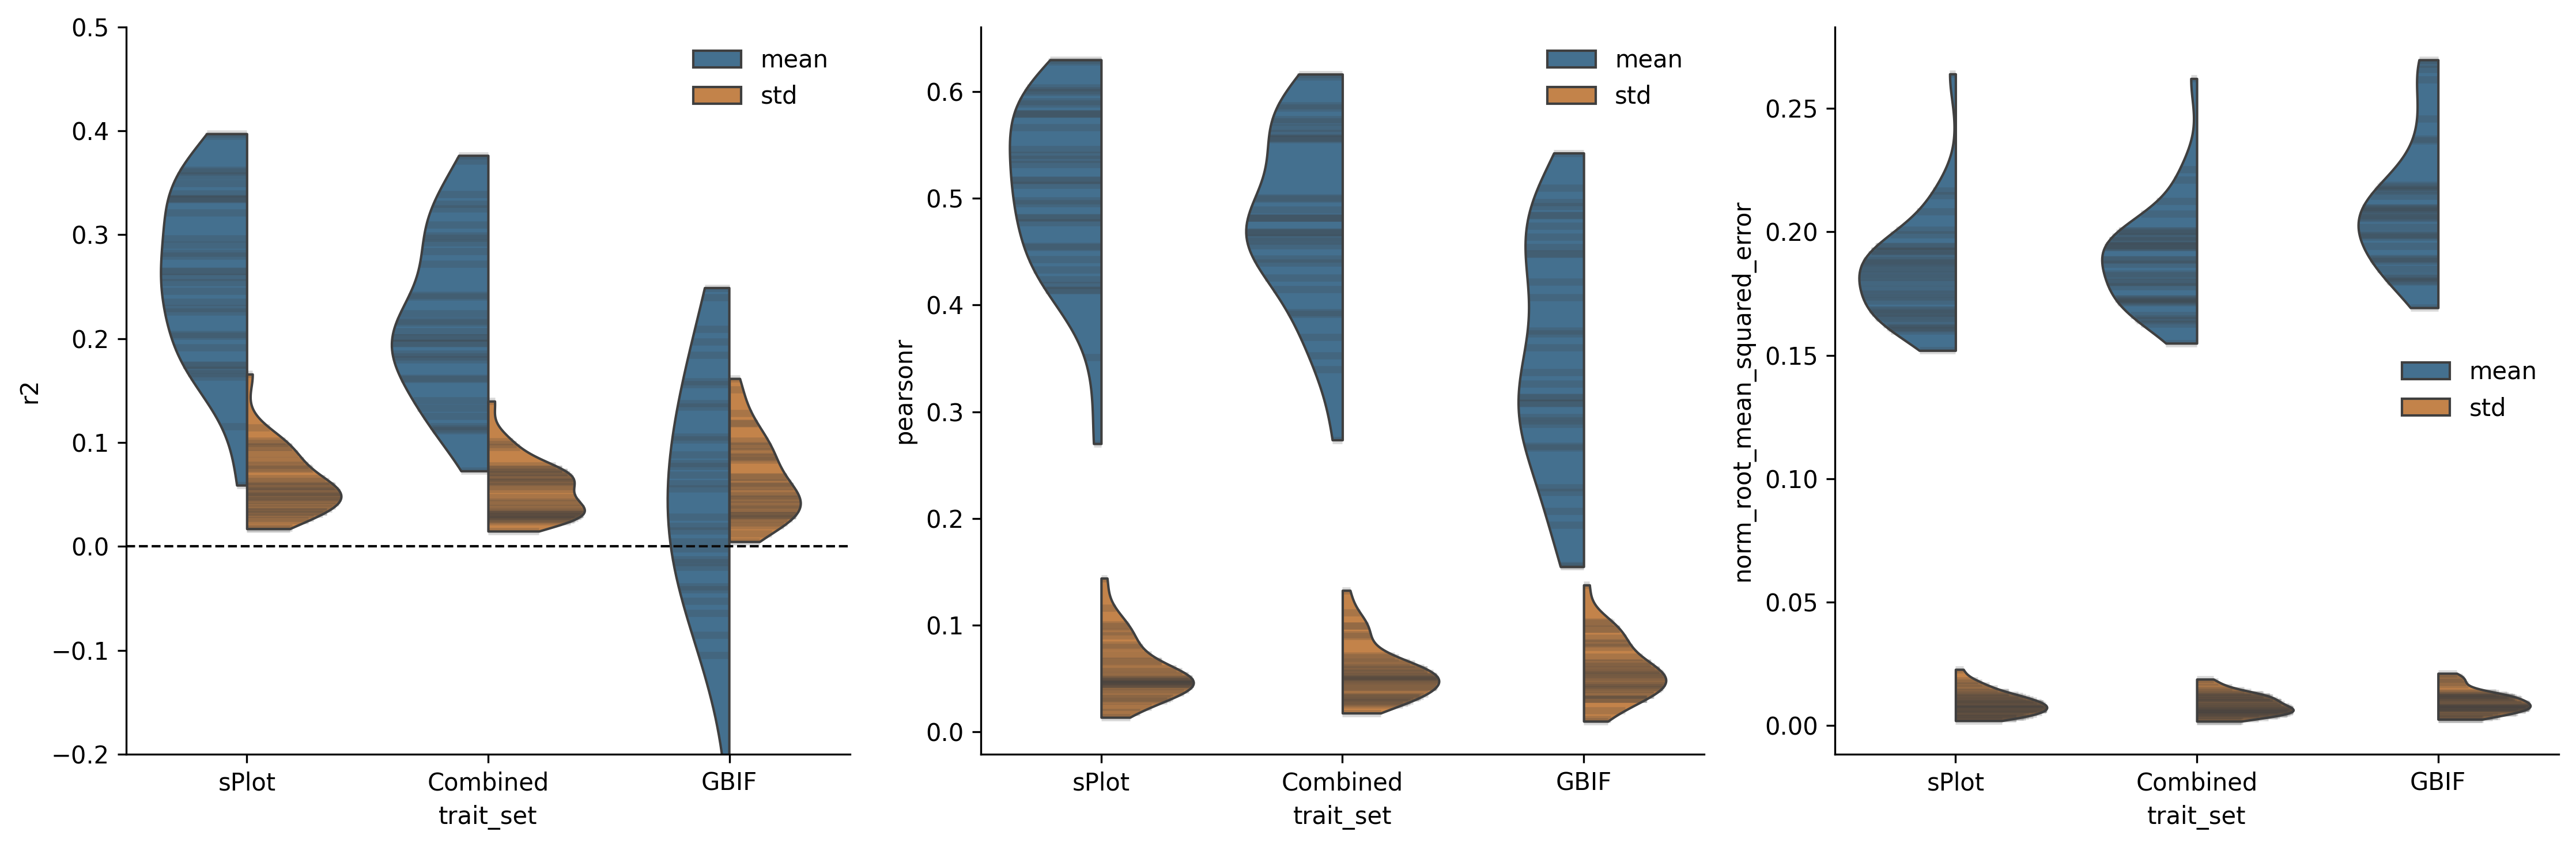

In [37]:
# Reset index to convert MultiIndex to columns
metrics = results.columns.get_level_values("metric").unique().values
df_long = results.stack(future_stack=True).reset_index()
metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]
fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(3 * 5, 5))

custom_order = ["splot", "splot_gbif", "gbif"]
custom_labels = ["sPlot", "Combined", "GBIF"]

for idx, metric in enumerate(metrics):
    ax = axs.flatten()[idx]
    df_metric = df_long[["trait_id", "trait_set", "agg", metric]]

    df_metric = df_metric.sort_values(by="trait_set", ascending=False)

    if metric == "norm_root_mean_squared_error":
        df_long[metric] = abs(df_long[metric])

    if metric == "r2":
        # add a horizontal line at 0
        ax.axhline(0, color="black", linestyle="--", linewidth=1)
        ax.set_ylim(-0.2, 0.5)

    # Plot the mean values
    sns.violinplot(
        x="trait_set",
        y=metric,
        data=df_long,
        hue="agg",
        split=True,
        ax=ax,
        inner="stick",
        # color="skyblue",
        linewidth=1,
        order=custom_order,
        # dodge=True
        cut=0,
        saturation=0.5,
        inner_kws={"linewidth": 3, "alpha": 0.2},
    )

    ax.set_xticks(ax.get_xticks(), custom_labels)
    ax.legend(frameon=False)
    sns.despine()

plt.tight_layout()
plt.show()

## Feature importance

Investigate the importance of the different datasets for each trait and then across trait sets.

In [2]:
model_dirs = [
    d for d in get_models_dir().glob("*") if d.is_dir() and d.name.startswith("X")
]

pd.read_csv(
    get_latest_run(model_dirs[0] / "autogluon") / "splot" / "feature_importance.csv",
    index_col=0,
    header=[0, 1],
)

importance              stddev            \
                                       mean       std      mean       std   
index                                                                       
ETH_GlobalCanopyHeightSD_2020_v1   0.000324  0.000236  0.000315  0.000130   
ETH_GlobalCanopyHeight_2020_v1     0.002452  0.000664  0.000597  0.000112   
bdod_0-5cm_mean                    0.001806  0.001132  0.000574  0.000163   
bdod_100-200cm_mean                0.000855  0.000342  0.000400  0.000155   
bdod_15-30cm_mean                  0.003186  0.003566  0.000799  0.000711   
...                                     ...       ...       ...       ...   
wc2.1_30s_bio_12                   0.004303  0.001116  0.000999  0.000203   
wc2.1_30s_bio_13-14                0.001935  0.000513  0.000607  0.000160   
wc2.1_30s_bio_15                   0.002364  0.001123  0.000853  0.000245   
wc2.1_30s_bio_4                    0.017236  0.007710  0.002017  0.000899   
wc2.1_30s_bio_7                    0.015760  0.009183  0.002090  0.001133   

                                       p_value                   n       \
                                          mean           std  mean  std   
index                                                                     
ETH_GlobalCanopyHeightSD_2020_v1  1.097421e-01  2.395751e-01  10.0  0.0   
ETH_GlobalCanopyHeight_2020_v1    2.315049e-06  4.210427e-06  10.0  0.0   
bdod_0-5cm_mean                   2.192015e-02  4.901229e-02  10.0  0.0   
bdod_100-200cm_mean               1.746053e-04  2.271824e-04  10.0  0.0   
bdod_15-30cm_mean                 1.151707e-06  1.147375e-06  10.0  0.0   
...                                        ...           ...   ...  ...   
wc2.1_30s_bio_12                  2.655874e-07  3.476264e-07  10.0  0.0   
wc2.1_30s_bio_13-14               2.111968e-06  1.348564e-06  10.0  0.0   
wc2.1_30s_bio_15                  1.643355e-03  3.657577e-03  10.0  0.0   
wc2.1_30s_bio_4                   9.701250e-10  1.374220e-09  10.0  0.0   
wc2.1_30s_bio_7                   3.817093e-09  6.771444e-09  10.0  0.0   

                                  p99_high                 p99_low            
                                      mean       std          mean       std  
index                                                                         
ETH_GlobalCanopyHeightSD_2020_v1  0.000648  0.000158  1.394902e-07  0.000349  
ETH_GlobalCanopyHeight_2020_v1    0.003066  0.000657  1.839101e-03  0.000691  
bdod_0-5cm_mean                   0.002396  0.001097  1.216255e-03  0.001190  
bdod_100-200cm_mean               0.001266  0.000415  4.437463e-04  0.000336  
bdod_15-30cm_mean                 0.004007  0.004295  2.364726e-03  0.002840  
...                                    ...       ...           ...       ...  
wc2.1_30s_bio_12                  0.005330  0.001294  3.275542e-03  0.000949  
wc2.1_30s_bio_13-14               0.002560  0.000670  1.311097e-03  0.000363  
wc2.1_30s_bio_15                  0.003240  0.001295  1.486864e-03  0.000986  
wc2.1_30s_bio_4                   0.019308  0.008589  1.516327e-02  0.006843  
wc2.1_30s_bio_7                   0.017908  0.010339  1.361244e-02  0.008031  

[150 rows x 12 columns]

In [42]:
def aggregate_fi() -> pd.DataFrame:
    """One df to rule them all."""
    model_dirs = [
        d for d in get_models_dir().glob("*") if d.is_dir() and d.name.startswith("X")
    ]

    results = []
    for model_dir in model_dirs:
        trait_id = model_dir.name
        run_dir = get_latest_run(model_dir / "autogluon")
        for trait_set in [d for d in run_dir.glob("*") if d.is_dir()]:
            trait_set_name = trait_set.name
            df = pd.read_csv(
                trait_set / cfg.train.feature_importance, index_col=0, header=[0, 1]
            ).reset_index(names=["feature"])

            def assign_dataset
            df["trait_id"] = get_trait_name_from_id(trait_id)[0]
            df["trait_set"] = trait_set_name
            df = df.set_index(["trait_id", "trait_set", "feature"])
            df.columns.names = ["metric", "agg"]
            df = df.stack("agg", future_stack=True)
            results.append(df)

    # return results
    return pd.concat(results)


results = aggregate_fi()
results.head(6)

metric                                                           importance  \
trait_id        trait_set feature                          agg                
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean    0.000324   
                                                           std     0.000236   
                          ETH_GlobalCanopyHeight_2020_v1   mean    0.002452   
                                                           std     0.000664   
                          bdod_0-5cm_mean                  mean    0.001806   
                                                           std     0.001132   

metric                                                             stddev  \
trait_id        trait_set feature                          agg              
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  0.000315   
                                                           std   0.000130   
                          ETH_GlobalCanopyHeight_2020_v1   mean  0.000597   
                                                           std   0.000112   
                          bdod_0-5cm_mean                  mean  0.000574   
                                                           std   0.000163   

metric                                                            p_value  \
trait_id        trait_set feature                          agg              
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  0.109742   
                                                           std   0.239575   
                          ETH_GlobalCanopyHeight_2020_v1   mean  0.000002   
                                                           std   0.000004   
                          bdod_0-5cm_mean                  mean  0.021920   
                                                           std   0.049012   

metric                                                              n  \
trait_id        trait_set feature                          agg          
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  10.0   
                                                           std    0.0   
                          ETH_GlobalCanopyHeight_2020_v1   mean  10.0   
                                                           std    0.0   
                          bdod_0-5cm_mean                  mean  10.0   
                                                           std    0.0   

metric                                                           p99_high  \
trait_id        trait_set feature                          agg              
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  0.000648   
                                                           std   0.000158   
                          ETH_GlobalCanopyHeight_2020_v1   mean  0.003066   
                                                           std   0.000657   
                          bdod_0-5cm_mean                  mean  0.002396   
                                                           std   0.001097   

metric                                                                p99_low  
trait_id        trait_set feature                          agg                 
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  1.394902e-07  
                                                           std   3.491544e-04  
                          ETH_GlobalCanopyHeight_2020_v1   mean  1.839101e-03  
                                                           std   6.913636e-04  
                          bdod_0-5cm_mean                  mean  1.216255e-03  
                                                           std   1.190410e-03

In [81]:
# add dataset identifier to each feature according to the following rules:
# startswith "ETH" -> canopy_height
# endswith "cm_mean" -> soilgrids
# startswith "wc"
# startswith "sur_refl" -> modis
# startswith "vodca" -> vodca
# starstwith "wc2.1" -> bioclim
# The feature names are the column names, and we want to add a new column "dataset" with the dataset identifier

results["dataset"] = "unknown"

# canopy height
mask = results.index.get_level_values("feature").str.startswith("ETH")
results.loc[mask, "dataset"] = "canopy_height"

# soilgrids
mask = results.index.get_level_values("feature").str.endswith("cm_mean")
results.loc[mask, "dataset"] = "soilgrids"

# modis
mask = results.index.get_level_values("feature").str.startswith("sur_refl")
results.loc[mask, "dataset"] = "modis"

# vodca
mask = results.index.get_level_values("feature").str.startswith("vodca")
results.loc[mask, "dataset"] = "vodca"

# bioclim
mask = results.index.get_level_values("feature").str.startswith("wc2.1")
results.loc[mask, "dataset"] = "bioclim"

results.head()

metric                                                           importance  \
trait_id        trait_set feature                          agg                
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean    0.000324   
                                                           std     0.000236   
                          ETH_GlobalCanopyHeight_2020_v1   mean    0.002452   
                                                           std     0.000664   
                          bdod_0-5cm_mean                  mean    0.001806   

metric                                                             stddev  \
trait_id        trait_set feature                          agg              
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  0.000315   
                                                           std   0.000130   
                          ETH_GlobalCanopyHeight_2020_v1   mean  0.000597   
                                                           std   0.000112   
                          bdod_0-5cm_mean                  mean  0.000574   

metric                                                            p_value  \
trait_id        trait_set feature                          agg              
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  0.109742   
                                                           std   0.239575   
                          ETH_GlobalCanopyHeight_2020_v1   mean  0.000002   
                                                           std   0.000004   
                          bdod_0-5cm_mean                  mean  0.021920   

metric                                                              n  \
trait_id        trait_set feature                          agg          
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  10.0   
                                                           std    0.0   
                          ETH_GlobalCanopyHeight_2020_v1   mean  10.0   
                                                           std    0.0   
                          bdod_0-5cm_mean                  mean  10.0   

metric                                                           p99_high  \
trait_id        trait_set feature                          agg              
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  0.000648   
                                                           std   0.000158   
                          ETH_GlobalCanopyHeight_2020_v1   mean  0.003066   
                                                           std   0.000657   
                          bdod_0-5cm_mean                  mean  0.002396   

metric                                                                p99_low  \
trait_id        trait_set feature                          agg                  
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  1.394902e-07   
                                                           std   3.491544e-04   
                          ETH_GlobalCanopyHeight_2020_v1   mean  1.839101e-03   
                                                           std   6.913636e-04   
                          bdod_0-5cm_mean                  mean  1.216255e-03   

metric                                                                 dataset  
trait_id        trait_set feature                          agg                  
Leaf fresh mass splot     ETH_GlobalCanopyHeightSD_2020_v1 mean  canopy_height  
                                                           std   canopy_height  
                          ETH_GlobalCanopyHeight_2020_v1   mean  canopy_height  
                                                           std   canopy_height  
                          bdod_0-5cm_mean                  mean      soilgrids

In [43]:
fi_long = (
    results.reset_index()
    .pivot_table(
        index=["trait_id", "trait_set", "agg"], columns=["feature"], values="importance"
    )
    .reset_index()
)

In [80]:
fi_long.head()

feature                 trait_id   trait_set   agg  \
0        Chromosome cDNA content        gbif  mean   
1        Chromosome cDNA content        gbif   std   
2        Chromosome cDNA content       splot  mean   
3        Chromosome cDNA content       splot   std   
4        Chromosome cDNA content  splot_gbif  mean   

feature  ETH_GlobalCanopyHeightSD_2020_v1  ETH_GlobalCanopyHeight_2020_v1  \
0                               -0.010755                        0.015628   
1                                0.016002                        0.019560   
2                                0.008429                        0.088647   
3                                0.006440                        0.032362   
4                               -0.002340                        0.056274   

feature  bdod_0-5cm_mean  bdod_100-200cm_mean  bdod_15-30cm_mean  \
0               0.004010            -0.003268          -0.004418   
1               0.007981             0.008759           0.007911   
2               0.025905             0.085841           0.026258   
3               0.016535             0.039059           0.018697   
4               0.023703             0.056029           0.026490   

feature  bdod_30-60cm_mean  bdod_5-15cm_mean  bdod_60-100cm_mean  \
0                -0.015012         -0.012122           -0.006760   
1                 0.009388          0.003012            0.008499   
2                 0.025223          0.053075            0.011129   
3                 0.018241          0.043794            0.009241   
4                 0.014262          0.012541            0.035593   

feature  cec_0-5cm_mean  cec_100-200cm_mean  cec_15-30cm_mean  \
0             -0.011470           -0.013893         -0.006476   
1              0.003194            0.007304          0.005043   
2              0.013941            0.013506          0.015798   
3              0.006715            0.009682          0.004746   
4              0.011118            0.005182          0.004182   

feature  cec_30-60cm_mean  cec_5-15cm_mean  cec_60-100cm_mean  \
0               -0.004748        -0.011983          -0.008861   
1                0.006527         0.006607           0.003474   
2                0.013357         0.015763           0.009780   
3                0.004265         0.007472           0.007154   
4                0.006774         0.002973          -0.001722   

feature  cfvo_0-5cm_mean  cfvo_100-200cm_mean  cfvo_15-30cm_mean  \
0              -0.013086            -0.010229          -0.012105   
1               0.013341             0.006381           0.016283   
2               0.030225             0.024703           0.017668   
3               0.011605             0.016706           0.014520   
4              -0.000073             0.003260          -0.006278   

feature  cfvo_30-60cm_mean  cfvo_5-15cm_mean  cfvo_60-100cm_mean  \
0                -0.021556         -0.029535           -0.016599   
1                 0.022253          0.037549            0.013528   
2                 0.037635          0.028720            0.024935   
3                 0.030676          0.010164            0.015780   
4                 0.000799         -0.002567            0.003071   

feature  clay_0-5cm_mean  clay_100-200cm_mean  clay_15-30cm_mean  \
0              -0.019195            -0.015584          -0.018639   
1               0.013318             0.007042           0.008337   
2               0.056126             0.007517           0.023660   
3               0.031029             0.003367           0.013685   
4              -0.006437             0.003340          -0.006784   

feature  clay_30-60cm_mean  clay_5-15cm_mean  clay_60-100cm_mean  \
0                -0.011732         -0.009242           -0.006890   
1                 0.003861          0.004821            0.004288   
2                 0.009243          0.032214            0.007908   
3                 0.007966          0.028843            0.007462   
4                -0.001456          0.001505 

In [77]:
fi_long.head()

feature                 trait_id   trait_set   agg  \
0        Chromosome cDNA content        gbif  mean   
1        Chromosome cDNA content        gbif   std   
2        Chromosome cDNA content       splot  mean   
3        Chromosome cDNA content       splot   std   
4        Chromosome cDNA content  splot_gbif  mean   

feature  ETH_GlobalCanopyHeightSD_2020_v1  ETH_GlobalCanopyHeight_2020_v1  \
0                               -0.010755                        0.015628   
1                                0.016002                        0.019560   
2                                0.008429                        0.088647   
3                                0.006440                        0.032362   
4                               -0.002340                        0.056274   

feature  bdod_0-5cm_mean  bdod_100-200cm_mean  bdod_15-30cm_mean  \
0               0.004010            -0.003268          -0.004418   
1               0.007981             0.008759           0.007911   
2               0.025905             0.085841           0.026258   
3               0.016535             0.039059           0.018697   
4               0.023703             0.056029           0.026490   

feature  bdod_30-60cm_mean  bdod_5-15cm_mean  bdod_60-100cm_mean  \
0                -0.015012         -0.012122           -0.006760   
1                 0.009388          0.003012            0.008499   
2                 0.025223          0.053075            0.011129   
3                 0.018241          0.043794            0.009241   
4                 0.014262          0.012541            0.035593   

feature  cec_0-5cm_mean  cec_100-200cm_mean  cec_15-30cm_mean  \
0             -0.011470           -0.013893         -0.006476   
1              0.003194            0.007304          0.005043   
2              0.013941            0.013506          0.015798   
3              0.006715            0.009682          0.004746   
4              0.011118            0.005182          0.004182   

feature  cec_30-60cm_mean  cec_5-15cm_mean  cec_60-100cm_mean  \
0               -0.004748        -0.011983          -0.008861   
1                0.006527         0.006607           0.003474   
2                0.013357         0.015763           0.009780   
3                0.004265         0.007472           0.007154   
4                0.006774         0.002973          -0.001722   

feature  cfvo_0-5cm_mean  cfvo_100-200cm_mean  cfvo_15-30cm_mean  \
0              -0.013086            -0.010229          -0.012105   
1               0.013341             0.006381           0.016283   
2               0.030225             0.024703           0.017668   
3               0.011605             0.016706           0.014520   
4              -0.000073             0.003260          -0.006278   

feature  cfvo_30-60cm_mean  cfvo_5-15cm_mean  cfvo_60-100cm_mean  \
0                -0.021556         -0.029535           -0.016599   
1                 0.022253          0.037549            0.013528   
2                 0.037635          0.028720            0.024935   
3                 0.030676          0.010164            0.015780   
4                 0.000799         -0.002567            0.003071   

feature  clay_0-5cm_mean  clay_100-200cm_mean  clay_15-30cm_mean  \
0              -0.019195            -0.015584          -0.018639   
1               0.013318             0.007042           0.008337   
2               0.056126             0.007517           0.023660   
3               0.031029             0.003367           0.013685   
4              -0.006437             0.003340          -0.006784   

feature  clay_30-60cm_mean  clay_5-15cm_mean  clay_60-100cm_mean  \
0                -0.011732         -0.009242           -0.006890   
1                 0.003861          0.004821            0.004288   
2                 0.009243          0.032214            0.007908   
3                 0.007966          0.028843            0.007462   
4                -0.001456          0.001505 

In [44]:
fi_comb_mn_imp = fi_long.query("trait_set == 'splot_gbif' & agg == 'mean'").drop(
    columns=["trait_set", "agg"]
).reset_index(drop=True).set_index(["trait_id"])

In [45]:
# Shift fi_comb_mn_imp to avoid negatives and then take natural log
fi_comb_mn_imp_shifted = fi_comb_mn_imp + abs(fi_comb_mn_imp.min()) + 1
fi_comb_mn_imp_log = np.log(fi_comb_mn_imp_shifted)

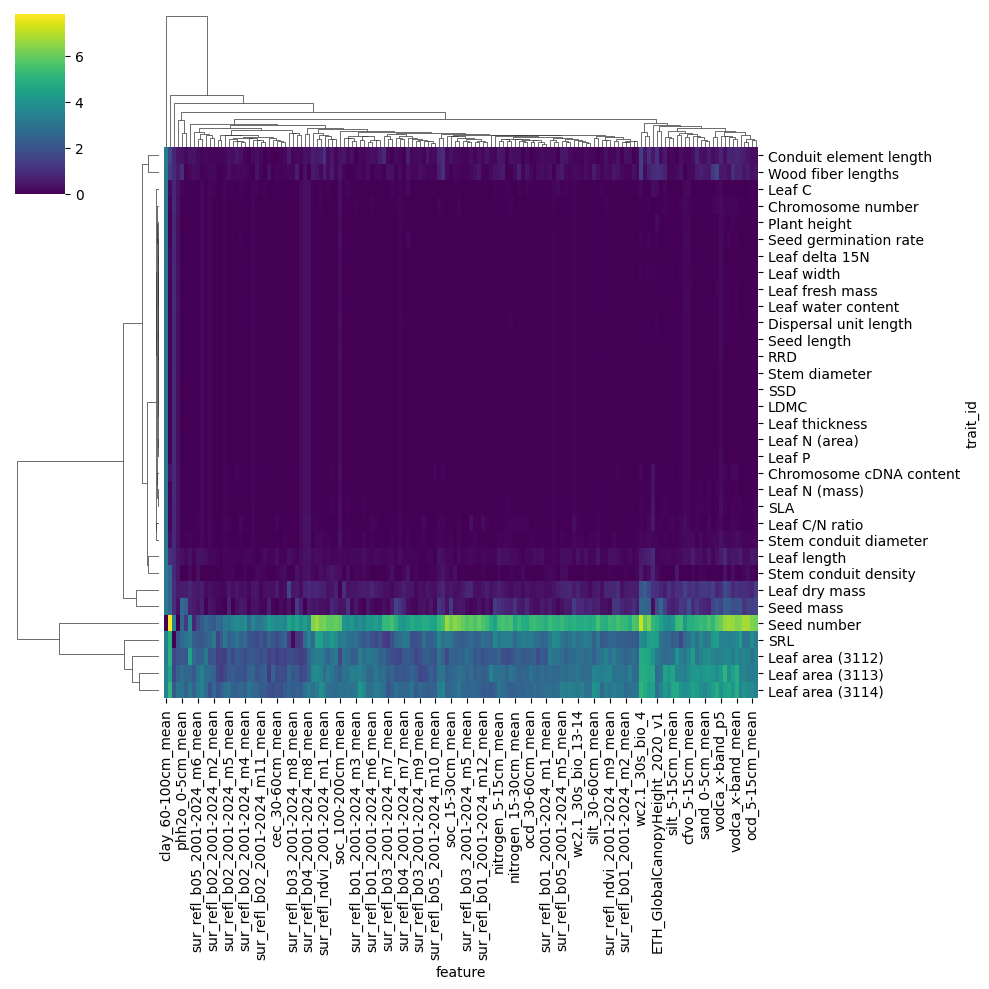

In [46]:
sns.clustermap(
    fi_comb_mn_imp_log,
    cmap="viridis",
    method="average",
    metric="euclidean",
    # figsize=(20, 20),
)

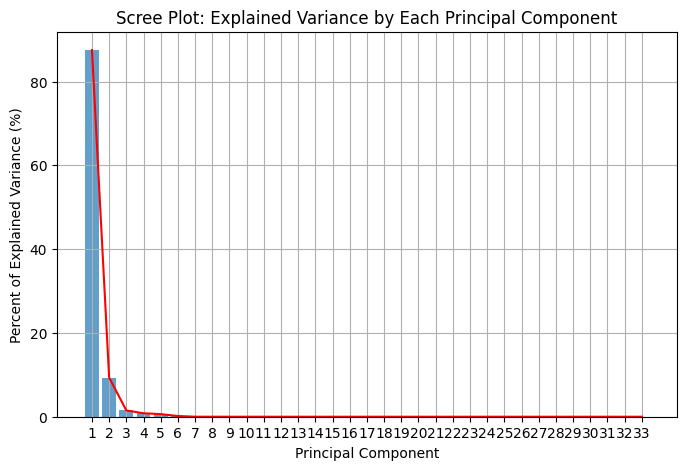

In [71]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df is your dataset, and 'trait_id' is not included in features
X = fi_comb_mn_imp.reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA without specifying the number of components
pca = PCA()
pca.fit(X_scaled)

# Get explained variance ratios for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a scree plot for the explained variance of each component
plt.figure(figsize=(8, 5))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio * 100,
    alpha=0.7,
)
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio * 100,
    # s=50,
    c="red",
    label="Explained Variance (%)",
)
plt.xlabel("Principal Component")
plt.ylabel("Percent of Explained Variance (%)")
plt.title("Scree Plot: Explained Variance by Each Principal Component")
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

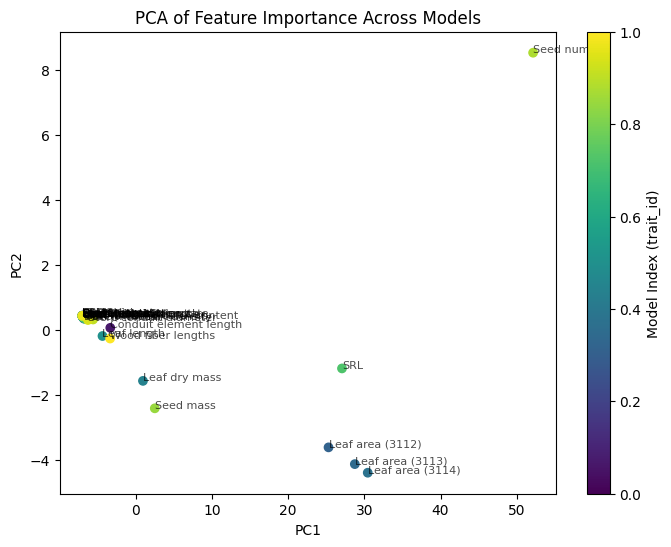

In [76]:
from sklearn.decomposition import PCA
import numpy as np

trait_ids = fi_comb_mn_imp_log.index

# Drop the trait_id column and apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(fi_comb_mn_imp_log.reset_index(drop=True))

# Scatter plot of the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(
    pca_result[:, 0], pca_result[:, 1], c=np.linspace(0, 1, len(fi_comb_mn_imp_log)), cmap="viridis"
)
plt.colorbar(label="Model Index (trait_id)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Feature Importance Across Models")

for i, trait_id in enumerate(trait_ids):
    plt.annotate(trait_id, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.7)

plt.show()

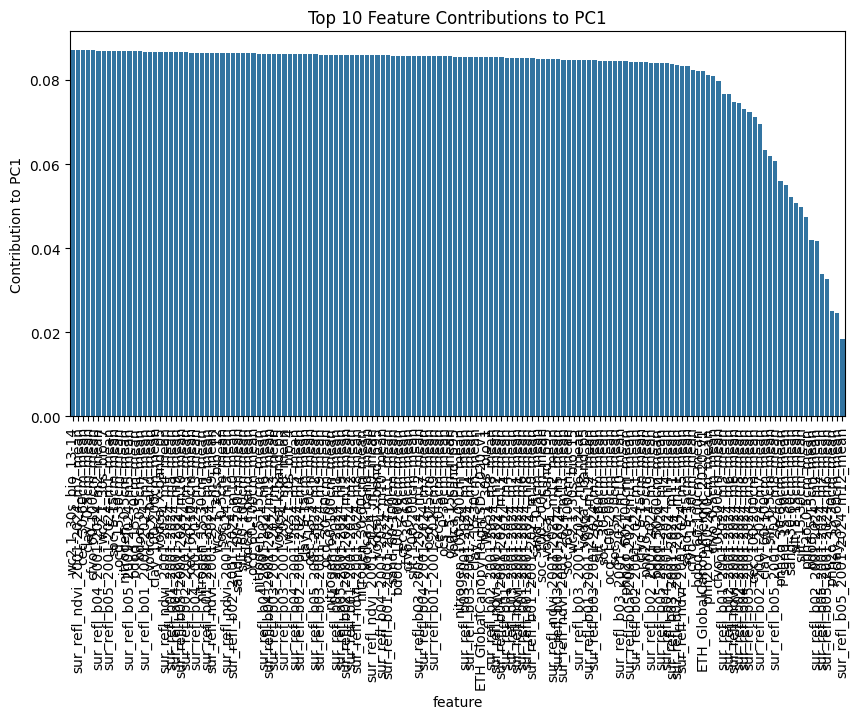

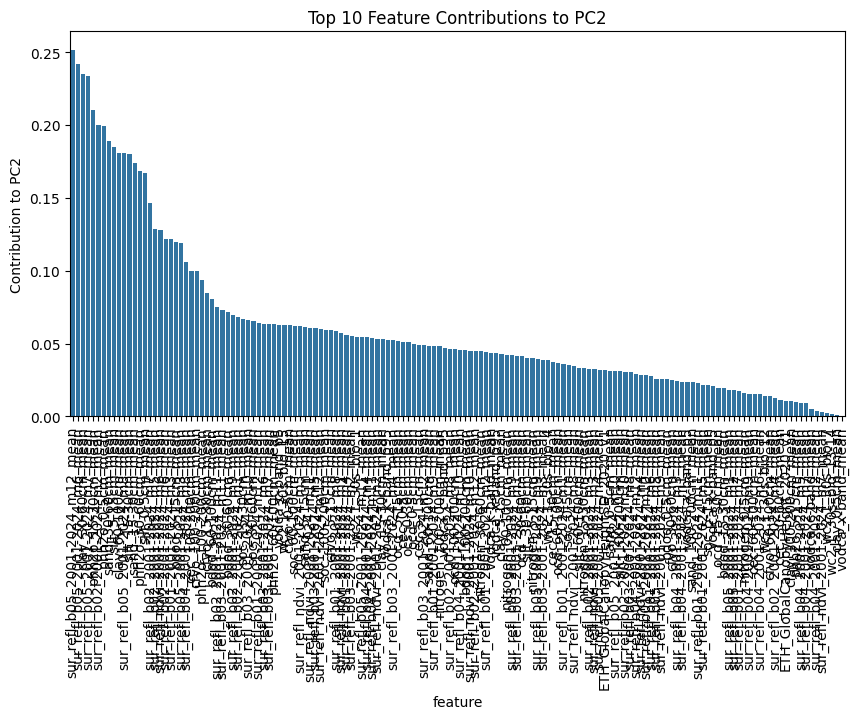

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume df has 150 features and 1 'trait_id' column
X = fi_comb_mn_imp.reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Get the loadings (contribution of each feature to PC1 and PC2)
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2"], index=X.columns)

# Sort loadings by absolute value to show the top contributing features for PC1
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(150)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(150)

# Bar plot for PC1
plt.figure(figsize=(10, 5))
sns.barplot(x=top_pc1.index, y=top_pc1.values)
plt.title("Top 10 Feature Contributions to PC1")
plt.xticks(rotation=90)
plt.ylabel("Contribution to PC1")
plt.show()

# Bar plot for PC2
plt.figure(figsize=(10, 5))
sns.barplot(x=top_pc2.index, y=top_pc2.values)
plt.title("Top 10 Feature Contributions to PC2")
plt.xticks(rotation=90)
plt.ylabel("Contribution to PC2")
plt.show()

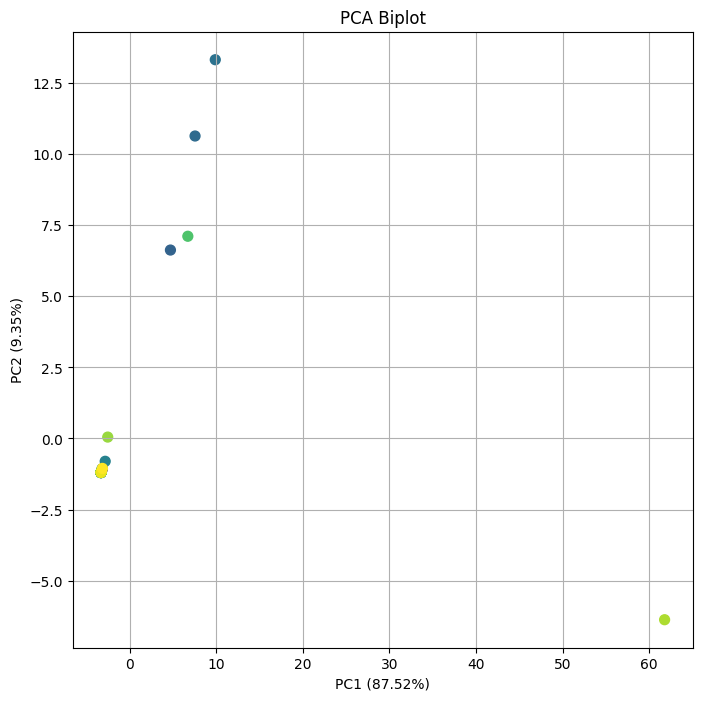

In [56]:
import numpy as np


# Function to create a biplot
def biplot(pca_model, scaled_data, labels, top_features=10):
    scores = pca_model.transform(scaled_data)  # PCA scores (PC1 and PC2)
    loadings = pca_model.components_.T * np.sqrt(
        pca_model.explained_variance_
    )  # Loadings for features

    plt.figure(figsize=(8, 8))

    # Scatter plot of scores (the actual samples in PC1 and PC2 space)
    plt.scatter(
        scores[:, 0],
        scores[:, 1],
        c=np.linspace(0, 1, len(scores)),
        cmap="viridis",
        s=50,
    )
    plt.xlabel(f"PC1 ({pca_model.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({pca_model.explained_variance_ratio_[1]*100:.2f}%)")

    # Add loading vectors (feature contributions)
    # for i, feature in enumerate(labels):
    #     plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color="r", alpha=0.5)
        # plt.text(
        #     loadings[i, 0] * 1.1,
        #     loadings[i, 1] * 1.1,
        #     feature,
        #     color="g",
        #     ha="center",
        #     va="center",
        # )

    plt.grid()
    plt.title("PCA Biplot")
    plt.show()


# Call the function for biplot
biplot(pca, X_scaled, X.columns)

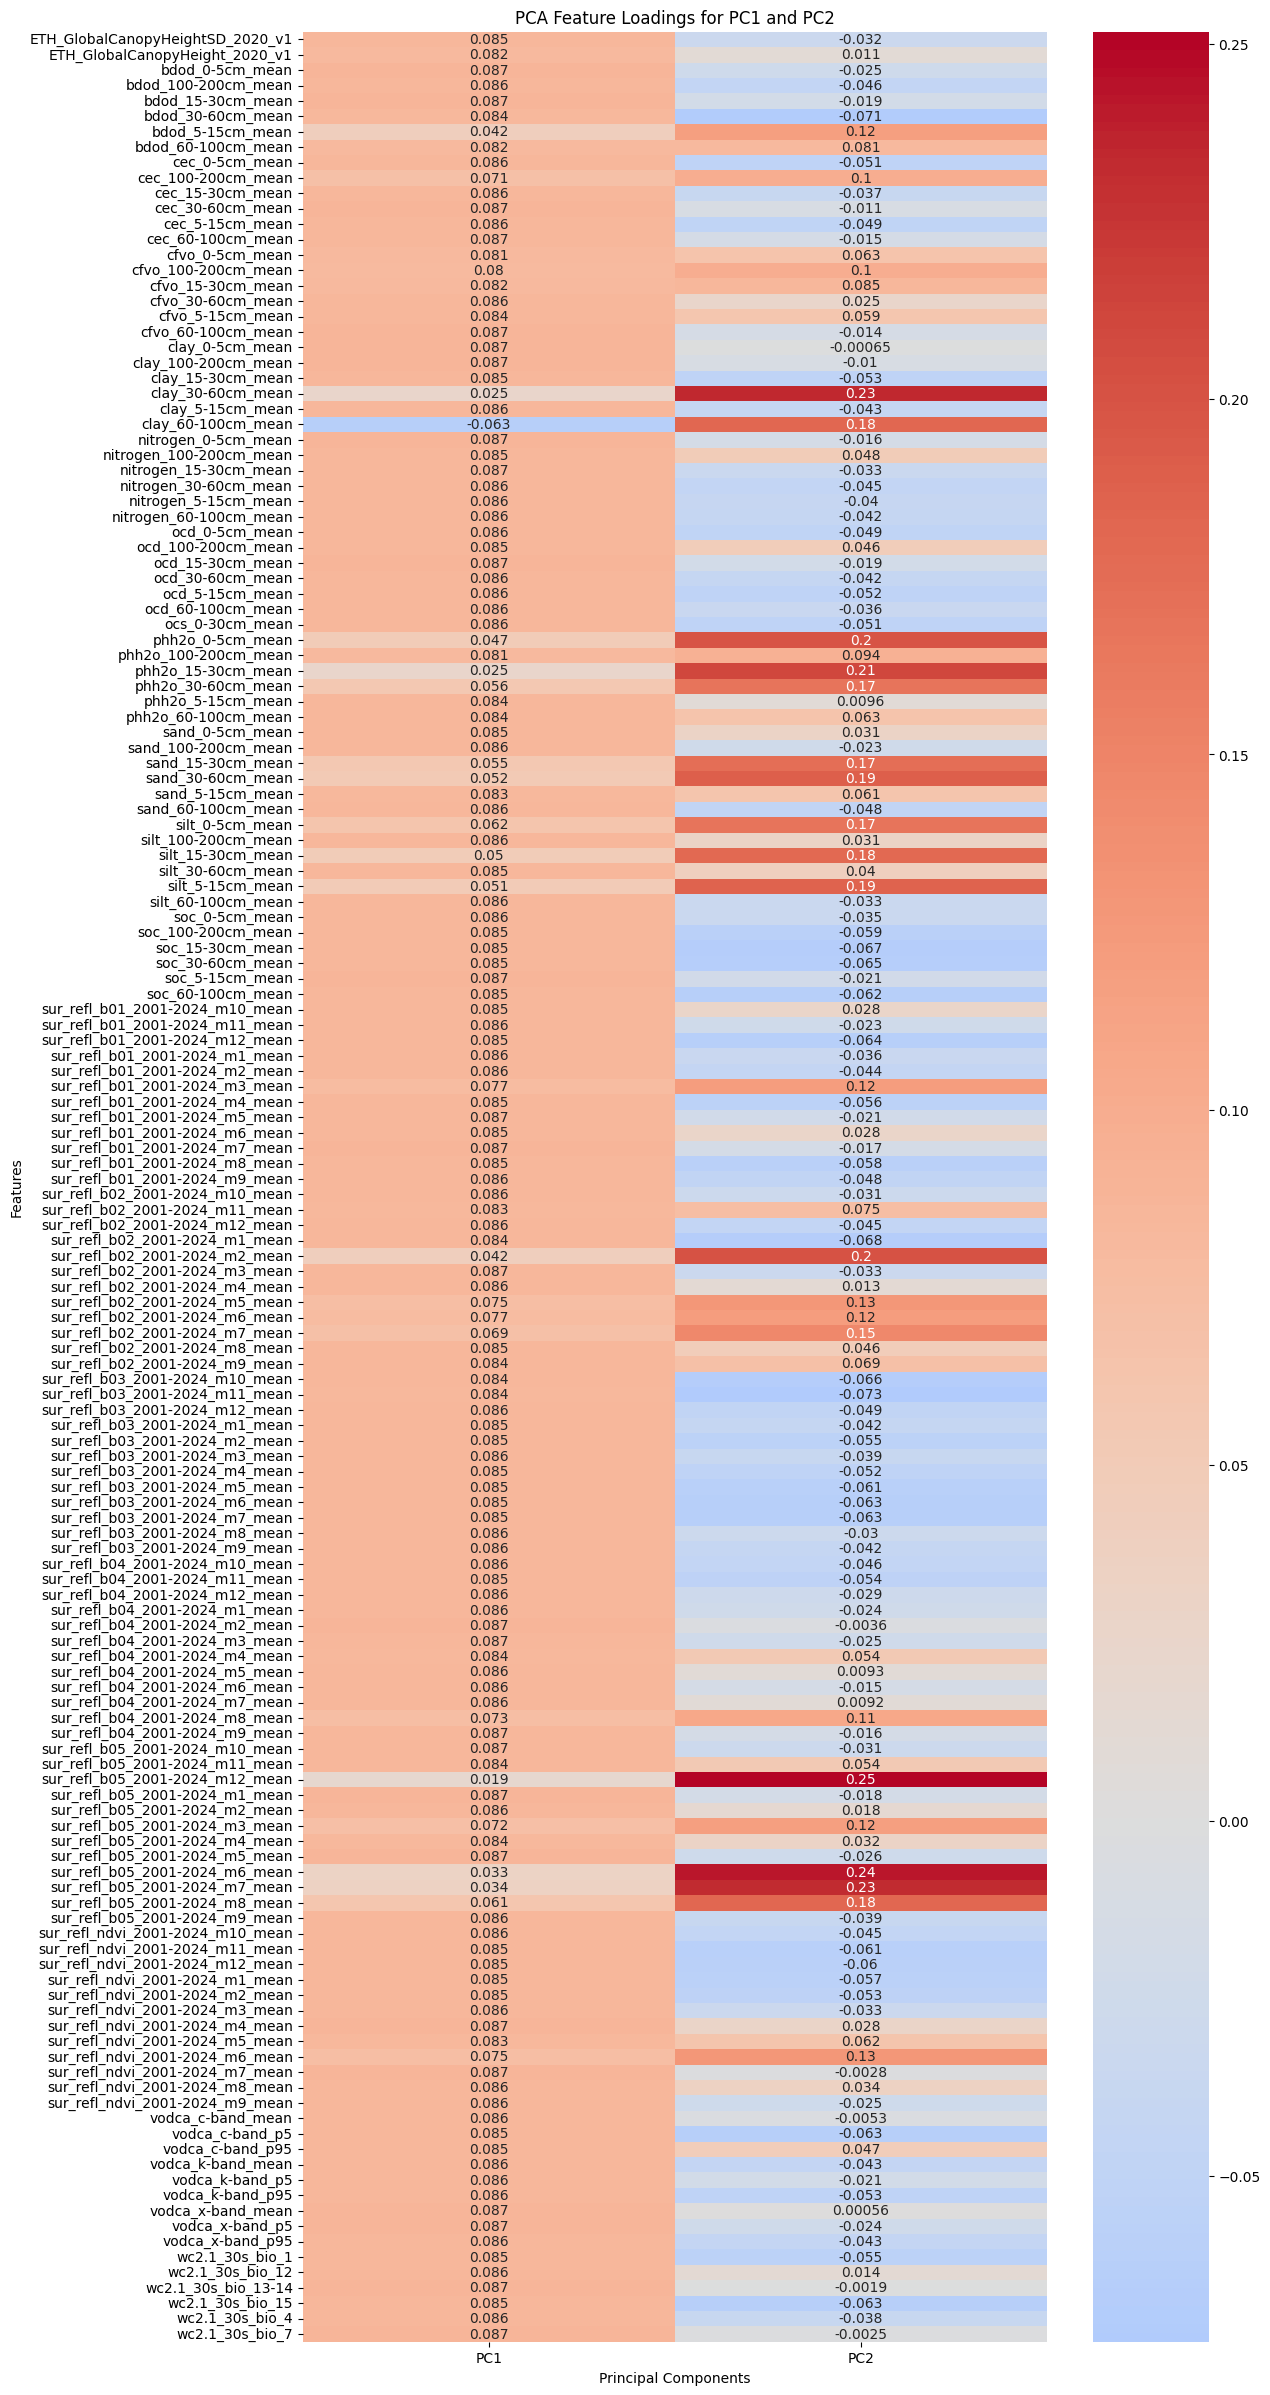

In [62]:
# Create a heatmap of loadings for the first two components
plt.figure(figsize=(12, 30))
sns.heatmap(loadings[["PC1", "PC2"]], annot=True, cmap="coolwarm", center=0)
plt.title("PCA Feature Loadings for PC1 and PC2")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.show()

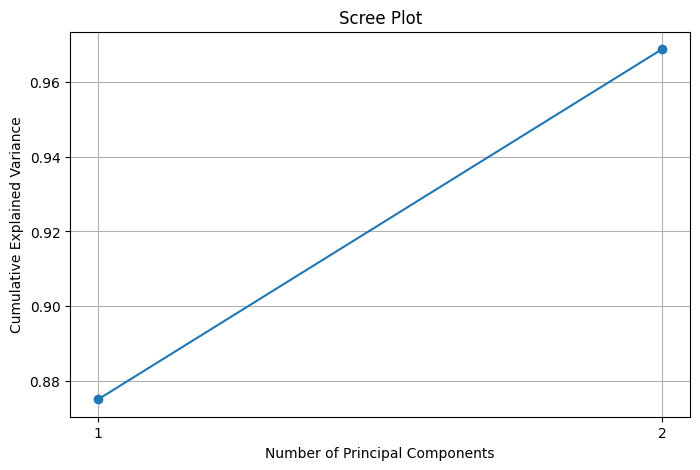

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(
    np.arange(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
)
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

## Area of Applicability